In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from IPython.display import Image
from numpy.lib import pad

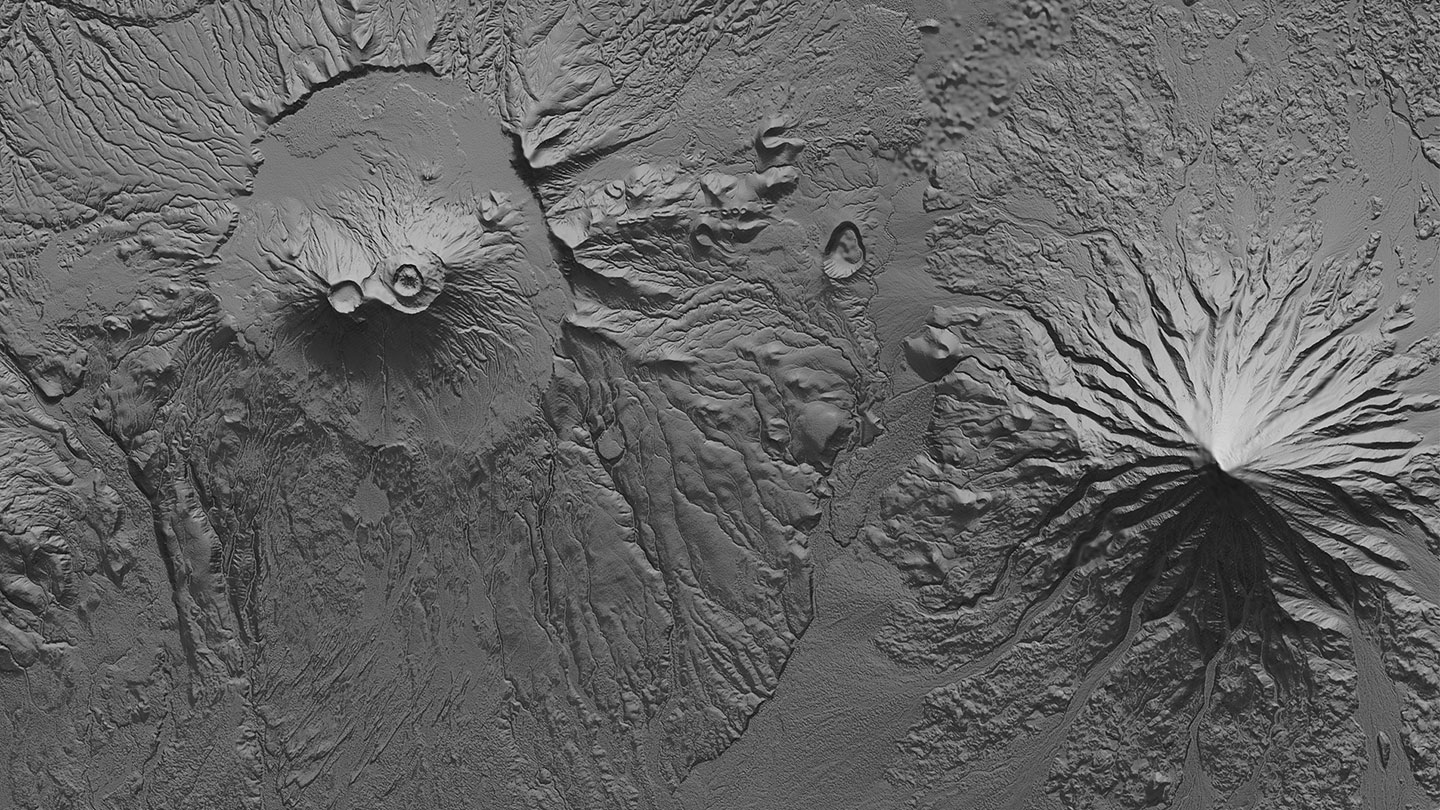

In [2]:
imagefile ='TDX_Vulkane_xl.jpg'
Image(imagefile, width=600)

<img src= 'TDX_Vulkane_xl.jpg' width=600px>

In [3]:
imdata = plt.imread(imagefile)


In [4]:
def rgb2gray(rgb):
    return np.abs(np.dot(rgb[..., :3],[0.299,0.587,0.114])+256)


grayscale_img1 = rgb2gray(imdata)
grayscale_img1.shape

(810, 1440)

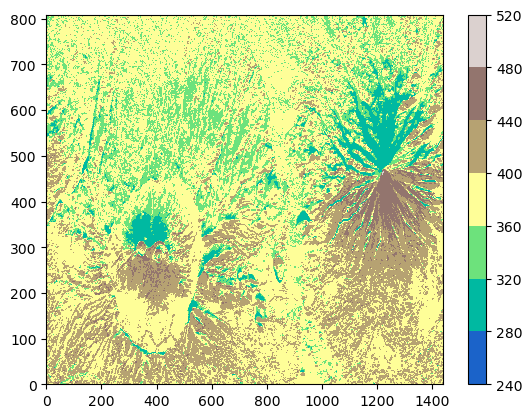

In [5]:
plt.figure()
plt.contourf(grayscale_img1, cmap='terrain')
plt.colorbar();

In [6]:
outdata = np.zeros_like(grayscale_img1)
print('vor pad',grayscale_img1.shape)
grayscale_img2 = pad(grayscale_img1, (1,1), 'reflect', reflect_type='odd')
print('nach pad',grayscale_img2.shape)

vor pad (810, 1440)
nach pad (812, 1442)


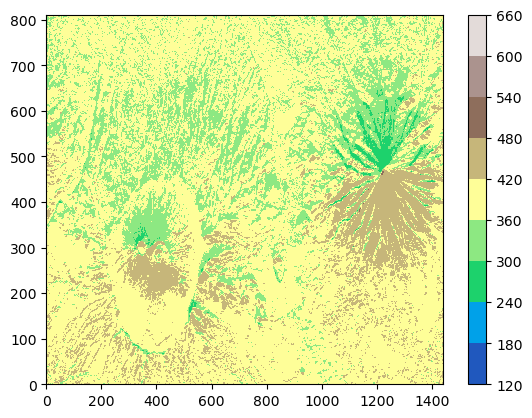

In [7]:
plt.figure()
plt.contourf(grayscale_img2, cmap='terrain')
plt.colorbar();

In [8]:
import math
# calculate gradient of image
def slope_cython1(indata, outdata):
    I = outdata.shape[0]
    J = outdata.shape[1]
    for i in range(I):
        for j in  range(J):
            dzdx =(indata[i+1, j]-indata[i+1, j+2]) / 2
            dzdy =(indata[i, j+1]-indata[i+2, j+1]) / 2
            slp = math.sqrt(dzdx * dzdx + dzdy * dzdy)
            outdata[i,j] = slp

In [9]:
%%timeit
slope_cython1(grayscale_img2, outdata)

1.74 s ± 38.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


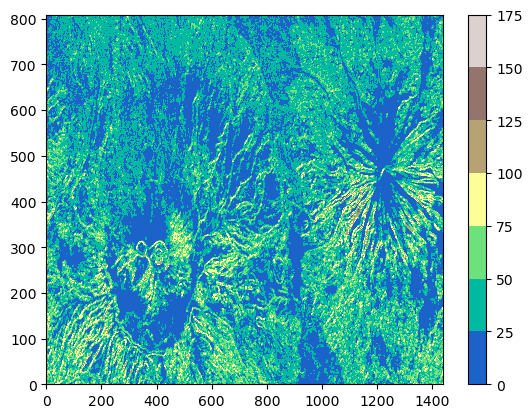

In [10]:
plt.figure()
plt.contourf(outdata, cmap='terrain')
plt.colorbar();

In [11]:
import cProfile
cProfile.run('slope_cython1(grayscale_img2, outdata)')

         1166404 function calls in 2.013 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    1.864    1.864    2.013    2.013 487969850.py:3(slope_cython1)
        1    0.000    0.000    2.013    2.013 <string>:1(<module>)
        1    0.000    0.000    2.013    2.013 {built-in method builtins.exec}
  1166400    0.149    0.000    0.149    0.000 {built-in method math.sqrt}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




In [31]:
%prun slope_cython1(grayscale_img2, outdata)
#print(f'slope_cython1(grayscale_img2, outdata)') 

         1166404 function calls in 2.133 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    1.987    1.987    2.133    2.133 487969850.py:3(slope_cython1)
  1166400    0.146    0.000    0.146    0.000 {built-in method math.sqrt}
        1    0.000    0.000    2.133    2.133 {built-in method builtins.exec}
        1    0.000    0.000    2.133    2.133 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}

In [18]:
%load_ext Cython 

In [25]:
%%cython -a
import cython # translate code from python to C
from libc.math cimport sqrt # import sqrt from C
# calculate gradient of image
def slope_cython2(double [:,:] indata, double [:,:] outdata):
    cdef int J, I 
    cdef int i, j
    cdef double slp, dzdx, dzdy
    I = outdata.shape[0]
    J = outdata.shape[1]
    for i in range(I):
        for j in  range(J):
            dzdx =(indata[i+1, j]-indata[i+1, j+2]) / 2
            dzdy =(indata[i, j+1]-indata[i+2, j+1]) / 2
            slp = sqrt(dzdx * dzdx + dzdy * dzdy)
            outdata[i,j] = slp

In [32]:
cProfile.run('slope_cython2(grayscale_img2, outdata)')

         4 function calls in 0.011 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.001    0.001    0.011    0.011 <string>:1(<module>)
        1    0.010    0.010    0.010    0.010 {_cython_magic_67709bff3e7ea268b8e759907e6696b3.slope_cython2}
        1    0.000    0.000    0.011    0.011 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




In [33]:
%%timeit
slope_cython2(grayscale_img2, outdata) 

9.75 ms ± 60.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [35]:
%%cython -a
import cython # translate code from python to C
from libc.math cimport sqrt # import sqrt from C
# calculate gradient of image
@cython.boundscheck(False) # turn off the check up of  boundary limits
def slope_cython3(double [:,:] indata, double [:,:] outdata):
    cdef int J, I 
    cdef int i, j
    cdef double slp, dzdx, dzdy
    I = outdata.shape[0]
    J = outdata.shape[1]
    for i in range(I):
        for j in  range(J):
            dzdx =(indata[i+1, j]-indata[i+1, j+2]) / 2
            dzdy =(indata[i, j+1]-indata[i+2, j+1]) / 2
            slp = sqrt(dzdx * dzdx + dzdy * dzdy)
            outdata[i,j] = slp

In [42]:
%%timeit
slope_cython3(grayscale_img2, outdata) 

6.72 ms ± 63.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [37]:
%%cython -a
import cython # translate code from python to C
from libc.math cimport sqrt # import sqrt from C
from cython.parallel import prange, parallel

# calculate gradient of image
@cython.boundscheck(False) # turn off the check up of  boundary limits
def slope_cython_openmp(double [:,:] indata, double [:,:] outdata):
    cdef int J, I 
    cdef int i, j
    cdef double slp, dzdx, dzdy
    I = outdata.shape[0]
    J = outdata.shape[1]

    with nogil, parallel(num_threads = 2):
        for i in prange(I, schedule='dynamic'): #parallel for 
            for j in  range(J):
                dzdx =(indata[i+1, j]-indata[i+1, j+2]) / 2
                dzdy =(indata[i, j+1]-indata[i+2, j+1]) / 2
                slp = sqrt(dzdx * dzdx + dzdy * dzdy)
                outdata[i,j] = slp

In [41]:
%%timeit
slope_cython_openmp(grayscale_img2, outdata) 

6.4 ms ± 27.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
